# *Lecture 28*

# Electromagnetic Waves

| |
|:---:|
|Selected Content [From **COMPUTATIONAL PHYSICS**, 3rd Ed, 2015](http://physics.oregonstate.edu/~rubin/Books/CPbook/index.html) <br>RH Landau, MJ Paez, and CC Bordeianu (deceased) <br>Copyrights: <br> [Wiley-VCH, Berlin;](http://www.wiley-vch.de/publish/en/books/ISBN3-527-41315-4/) and [Wiley & Sons, New York](http://www.wiley.com/WileyCDA/WileyTitle/productCd-3527413154.html)<br>  R Landau, Oregon State Unv, <br>MJ Paez, Univ Antioquia,<br> C Bordeianu, Univ Bucharest, 2015.<br> Support by National Science Foundation.|

# Electromagnetic Waves


Just as we used finite differences to rewrite Schrödinger's equation, we can also use finite differences to rewrite Maxwell's equations for electromagnetic fields.
This implies again a discrete grid in space and time, on which we perform time stepping to calculate the evolution of the system.
Such a grid is called a **Yee grid**, after the inventor of the method for EM simulations.
The original paper [Kane Yee, "Numerical solution of initial boundary value problems involving Maxwell's equations in isotropic media"](https://doi.org/10.1109/TAP.1966.1138693) is suprisingly readable and gives a good description of the "finite difference time domain" (FDTD) method, although it did not get that name until 1980.

Allen Taflove, who coined the FDTD name, said in [an interview with Nature](http://www.nature.com/nphoton/journal/v9/n1/full/nphoton.2014.305.html), "*Not many people know that Kane Yee was simply learning how to program in Fortran, as he told me 20 years later. He chose Maxwell's time-dependent curl equations as the basis of his self-study because he wanted an initial-value problem that had both time and space derivatives.... Having almost given up on [my dissertation] problem, I spotted Yee's 1966 paper by accident while randomly leafing through back issues of journals. I had seen no citations to Yee.*"

This particular approach, when applied to EM simulations, is called the **finite difference time domain** method.
The alternative method is called the [finite difference frequency domain method](https://en.wikipedia.org/wiki/Finite-difference_frequency-domain_method).  That method rewrites Maxwell's equations as matrix operators for a constant frequency, so that there is no need for time stepping.  The large matrix equation, which may have hundreds of thousands of elements, is solved all at once.

Before going on, we should note that the Yee grid is usually composed of rectangular elements.  If the region to be studied is not rectangular, then it is broken up into a fine mesh of small rectangular elements.
The spacing of the grid must be smaller than the electromagnetic wavelengths, so that the induced $E$ and $H$ fields are calculated correctly.

## Maxwell's Equations

We follow the notation of the text, calculating $E$ and $H$ in an arbitrary medium.

<img src="Figures/Figure_22.7.png" width="40%">

The Cartesian formulas assume 1-dimensional propagation, namely along $z$, with $E$ polarized (pointing) in the $x$ direction.
$H$ is therefore polarized in the $y$ direction.

$$\begin{align}
{\bf \nabla} \cdot \mathbf{E}  =  0 \\
\Rightarrow& \ \frac{\partial E_x(z,t)}{\partial x} = 0\\
{\bf \nabla} \cdot \mathbf{H} = 0 \\
\Rightarrow& \ \frac{\partial
H_y(z,t)}{\partial y} = 0,\\
 \frac{\partial \mathbf{E}} {\partial t} =+\frac{1}{\epsilon_0}
{\bf \nabla}\times \mathbf{H}\\
\Rightarrow&
\  \frac{\partial E_x}{\partial t} =- \frac{1}{\epsilon_0}
\frac{\partial
H_y(z,t)}{\partial z},\\
\frac{\partial\mathbf{H}} {\partial t}  = -\frac{1}{\mu_0}
{\bf \nabla}\times \mathbf{E}\\
\Rightarrow& \ \frac{\partial H_y}{\partial t} =- \frac{1}{\mu_0}
\frac{\partial E_x(z,t)}{\partial z}
\end{align}$$

### Discretization and Finite Differences

The partial differential equations above have coupled spatial and time derivatives.
We use the central-difference approximation to ensure the accuracy of the derivatives.
For example, the third equation could be rewritten as 

$$
\frac{E_x(z,t+\frac{\Delta t}{2})-E_x(z,t-\frac{\Delta t}{2})}{\Delta
t} = -\frac{1}{\epsilon_0} \frac{H_y(z+\frac{\Delta z}{2},t)-H_y(z-\frac{\Delta z}{2},t)}{\Delta
z}
$$

The nice thing is that Maxwell's equations have only first derivatives and no second derivatives!

*Exercise*: Do the electromagnetic fields satisfy the wave equation?  If not, where do the waves come from?

One could imagine evaluating the $E$ fields and $H$ fields at different time steps ($t \pm \frac{\Delta t}{2}$ vs. $t$), exactly the same as for the real and imaginary parts of the quantum wavefunction $\psi$.
Even though the evaluations can happen at different times, we still have a question about *where* to evaluate the two separate fields.
  
The novelty of the FDTD scheme is to evaluate the finite difference equations on staggered grids in time *and* space for each electric and magnetic vector field component in Maxwell's curl equations.

<img src="Figures/FDTD_Yee_grid_2d-3d.png" width="60%">

This is fundamentally different from the $R$ and $I$ components of $\psi$, which were evaluated at the same space points but different time points.

Practically, we will rewrite the finite difference version of Maxwell's equations with the explicit evaluations at points given by indices $k$ (space) and $n$ (time):

$$\begin{align}
 \frac{E_x^{k,n+1/2} - E_x^{k,n-1/2}}{\Delta t}
   & =  -\frac{H_y^{k+1/2,n} - H_y^{k-1/2,n}}{\epsilon_0\Delta z},\\
\frac{H_y^{k+1/2, n+1} -H_y^{k+1/2, n} }{\Delta t} & =
-\frac{E_x^{k+1,n+1/2}-E_x^{k,n+1/2}} {\mu_0\Delta z}.
  \end{align}$$

This formulation solves for the electric
field at integer space steps ($k$) but half-integer time steps ($n$),
while the magnetic field is solved for at half-integer space steps but
integer time steps.

Now we convert these equations into two simultaneous algorithms by solving for
$E_x$ at time $n+\frac{1}{2}$, and $H_y$ at time $n$:

$$\begin{align}
  E_x^{k,n+1/2} & =  E_x^{k,n-1/2}
  - \frac{\Delta t}{\epsilon_0  \Delta z}
  \big( H_y^{k+1/2, n}-H_y^{k-1/2, n}\big),\\
  H_y^{k+1/2, n+1} & =  H_y^{k+1/2,n}
  - \frac{\Delta t}{\mu_0\Delta z} \big( E_x^{k+1,n+1/2}
  -E_x^{k,n+1/2}\big)
\end{align}$$

The graphical version of the last equation is given in the figure below.
We have two
interleaved lattices, with the electric fields determined at
half-integer times on lattice 1 and the magnetic fields at integer times
on lattice 2.

<img src="Figures/Figure_22.8.png" width="40%">


### Implementation 

In the following code, $\tilde{E}= \sqrt{\frac{\epsilon_0}{\mu_0}} {E}$ has been adjusted to have the same units as $H$.
With those units, we have (suppressing the tilde, which doesn't show up well in the notebook):

$$
\begin{align}
   E_x^{k,n+1/2}  &=   E_x^{k,n-1/2}
  +\beta     \left( H_y^{k-1/2, n} - H_y^{k+1/2, n}\right) \\
    H_y^{k+1/2, n+1}  &=   H_y^{k+1/2,n}
  +\beta  \left( E_x^{k,n+1/2} -E_x^{k+1,n+1/2}
  \right)
\end{align}
$$

$$\beta   =   \frac{c}{\Delta z/\Delta t}, \quad c = \frac{1}{\sqrt{\epsilon_0\mu_0}}.$$

Here $c$ is the speed of light in a vacuum and $\beta$ is the ratio of
the speed of light to "grid velocity" $\Delta z/\Delta t$.

(Note: this latter quantity "grid velocity" is *not* the same as the wave velocity, because $\Delta z$ and $\Delta t$ are arbitrary in the numerical algorithm.)

The initial conditions for the fields are set to 
$$E_x (z, t=0)\ =\ 0.1 \sin \frac{2\pi z}{L}, \quad\quad H_y(z,
t=0) \ =\ 0.1 \sin\frac{2\pi z}{L},$$

The updates of $E_x$ and $H_y$ pull from staggered positions in $x$, but in this implementation the updates happen at the same time steps.
* How would you change the implementation to stagger the time steps?
* What are the boundary conditions used in this implementation?
* What happens if beta changes?
* What happens if $c$ changes?

beta = 0.04


<IPython.core.display.Javascript object>


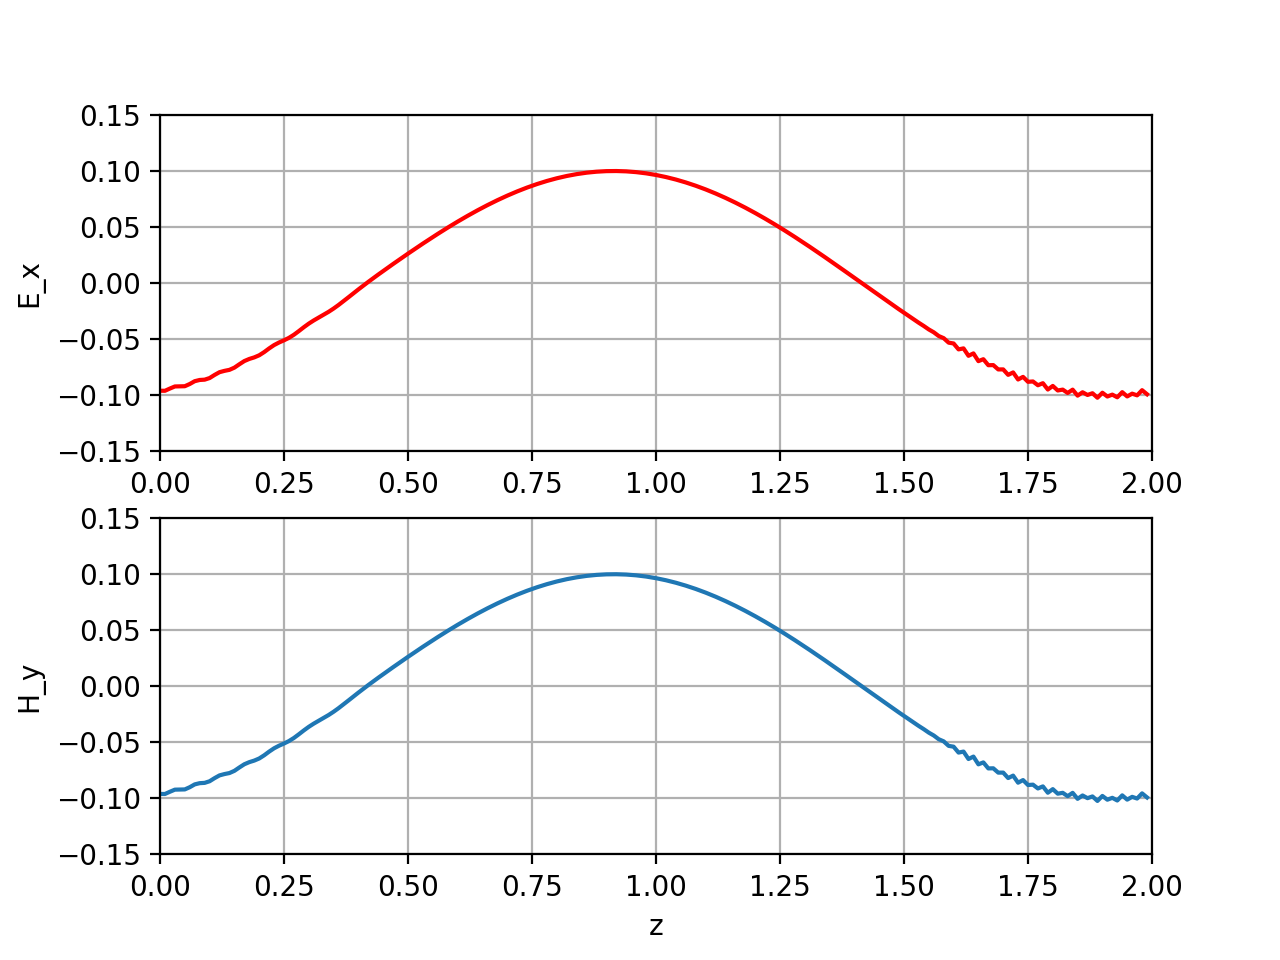

In [1]:
""" From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python eTextBook  
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# FDTD.py  FDTD solution of Maxwell's equations in 1-D

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

zmax = 2.0
dz = 0.01
zs = np.arange(0., zmax, dz)

ts = 2                          # time buffer switch
c = 0.4
dt = 0.001
beta = c * dt / dz
print('beta =', beta)
Ex = np.zeros((len(zs),ts))      # init E 
Hy = np.zeros((len(zs),ts))      # init H 

fig = plt.figure()
ax1 = fig.add_subplot(211, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax2 = fig.add_subplot(212, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax1.grid(); ax2.grid()
ax2.set_xlabel('z')
ax1.set_ylabel('E_x'); ax2.set_ylabel('H_y')

ex_curve, = ax1.plot(zs, Ex[:,0], '-r')
hy_curve, = ax2.plot(zs, Hy[:,0], '-')

def init():
    Ex[:,0] = 0.1*np.sin(2*np.pi*zs/zmax)
    Hy[:,0] = 0.1*np.sin(2*np.pi*zs/zmax)
    ex_curve.set_ydata(Ex[:,0])
    hy_curve.set_ydata(Hy[:,0])
    return ex_curve, hy_curve

def animate(i):
    Ex[1:-1,1] = Ex[1:-1,0] + beta*(Hy[0:-2,0]-Hy[2:,0])
    Hy[1:-1,1] = Hy[1:-1,0] + beta*(Ex[0:-2,0]-Ex[2:,0])

    Ex[0,1]    = Ex[0,0]    + beta*(Hy[-2,0]  -Hy[1,0]) # BC
    Ex[-1,1]   = Ex[-1,0]   + beta*(Hy[-2,0]  -Hy[1,0])  
    Hy[0,1]    = Hy[0,0]    + beta*(Ex[-2,0]  -Ex[1,0]) # BC
    Hy[-1,1]   = Hy[-1,0]   + beta*(Ex[-2,0] - Ex[1,0]) 
    
    Ex[:,0] = Ex[:,1]                            # New->old
    Hy[:,0] = Hy[:,1]                                  
    
    ex_curve.set_ydata(Ex[:,0])
    hy_curve.set_ydata(Hy[:,0])
    return ex_curve, hy_curve

ani = animation.FuncAnimation(fig, animate, np.arange(1, 10000),
                              interval=1, blit=True, init_func=init)

One of the advantages of the FDTD method is that we can deal with spatial variations in $\beta$, corresponding to changes in $c$ (or $\epsilon$).

This could be the case for an EM wave passing through an object with $\epsilon \neq \epsilon_0$ -- a lens!

In the following code, we change $\beta$ for the central half of the 1-D interval and see what happens.
This requires us to maintain the value of $\beta$ for every point in the interval.
It is our first foray into creating the position "mesh" that would include material properties and shapes.

The printouts are there to highlight the difference in time coordinates.

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

<IPython.core.display.Javascript object>


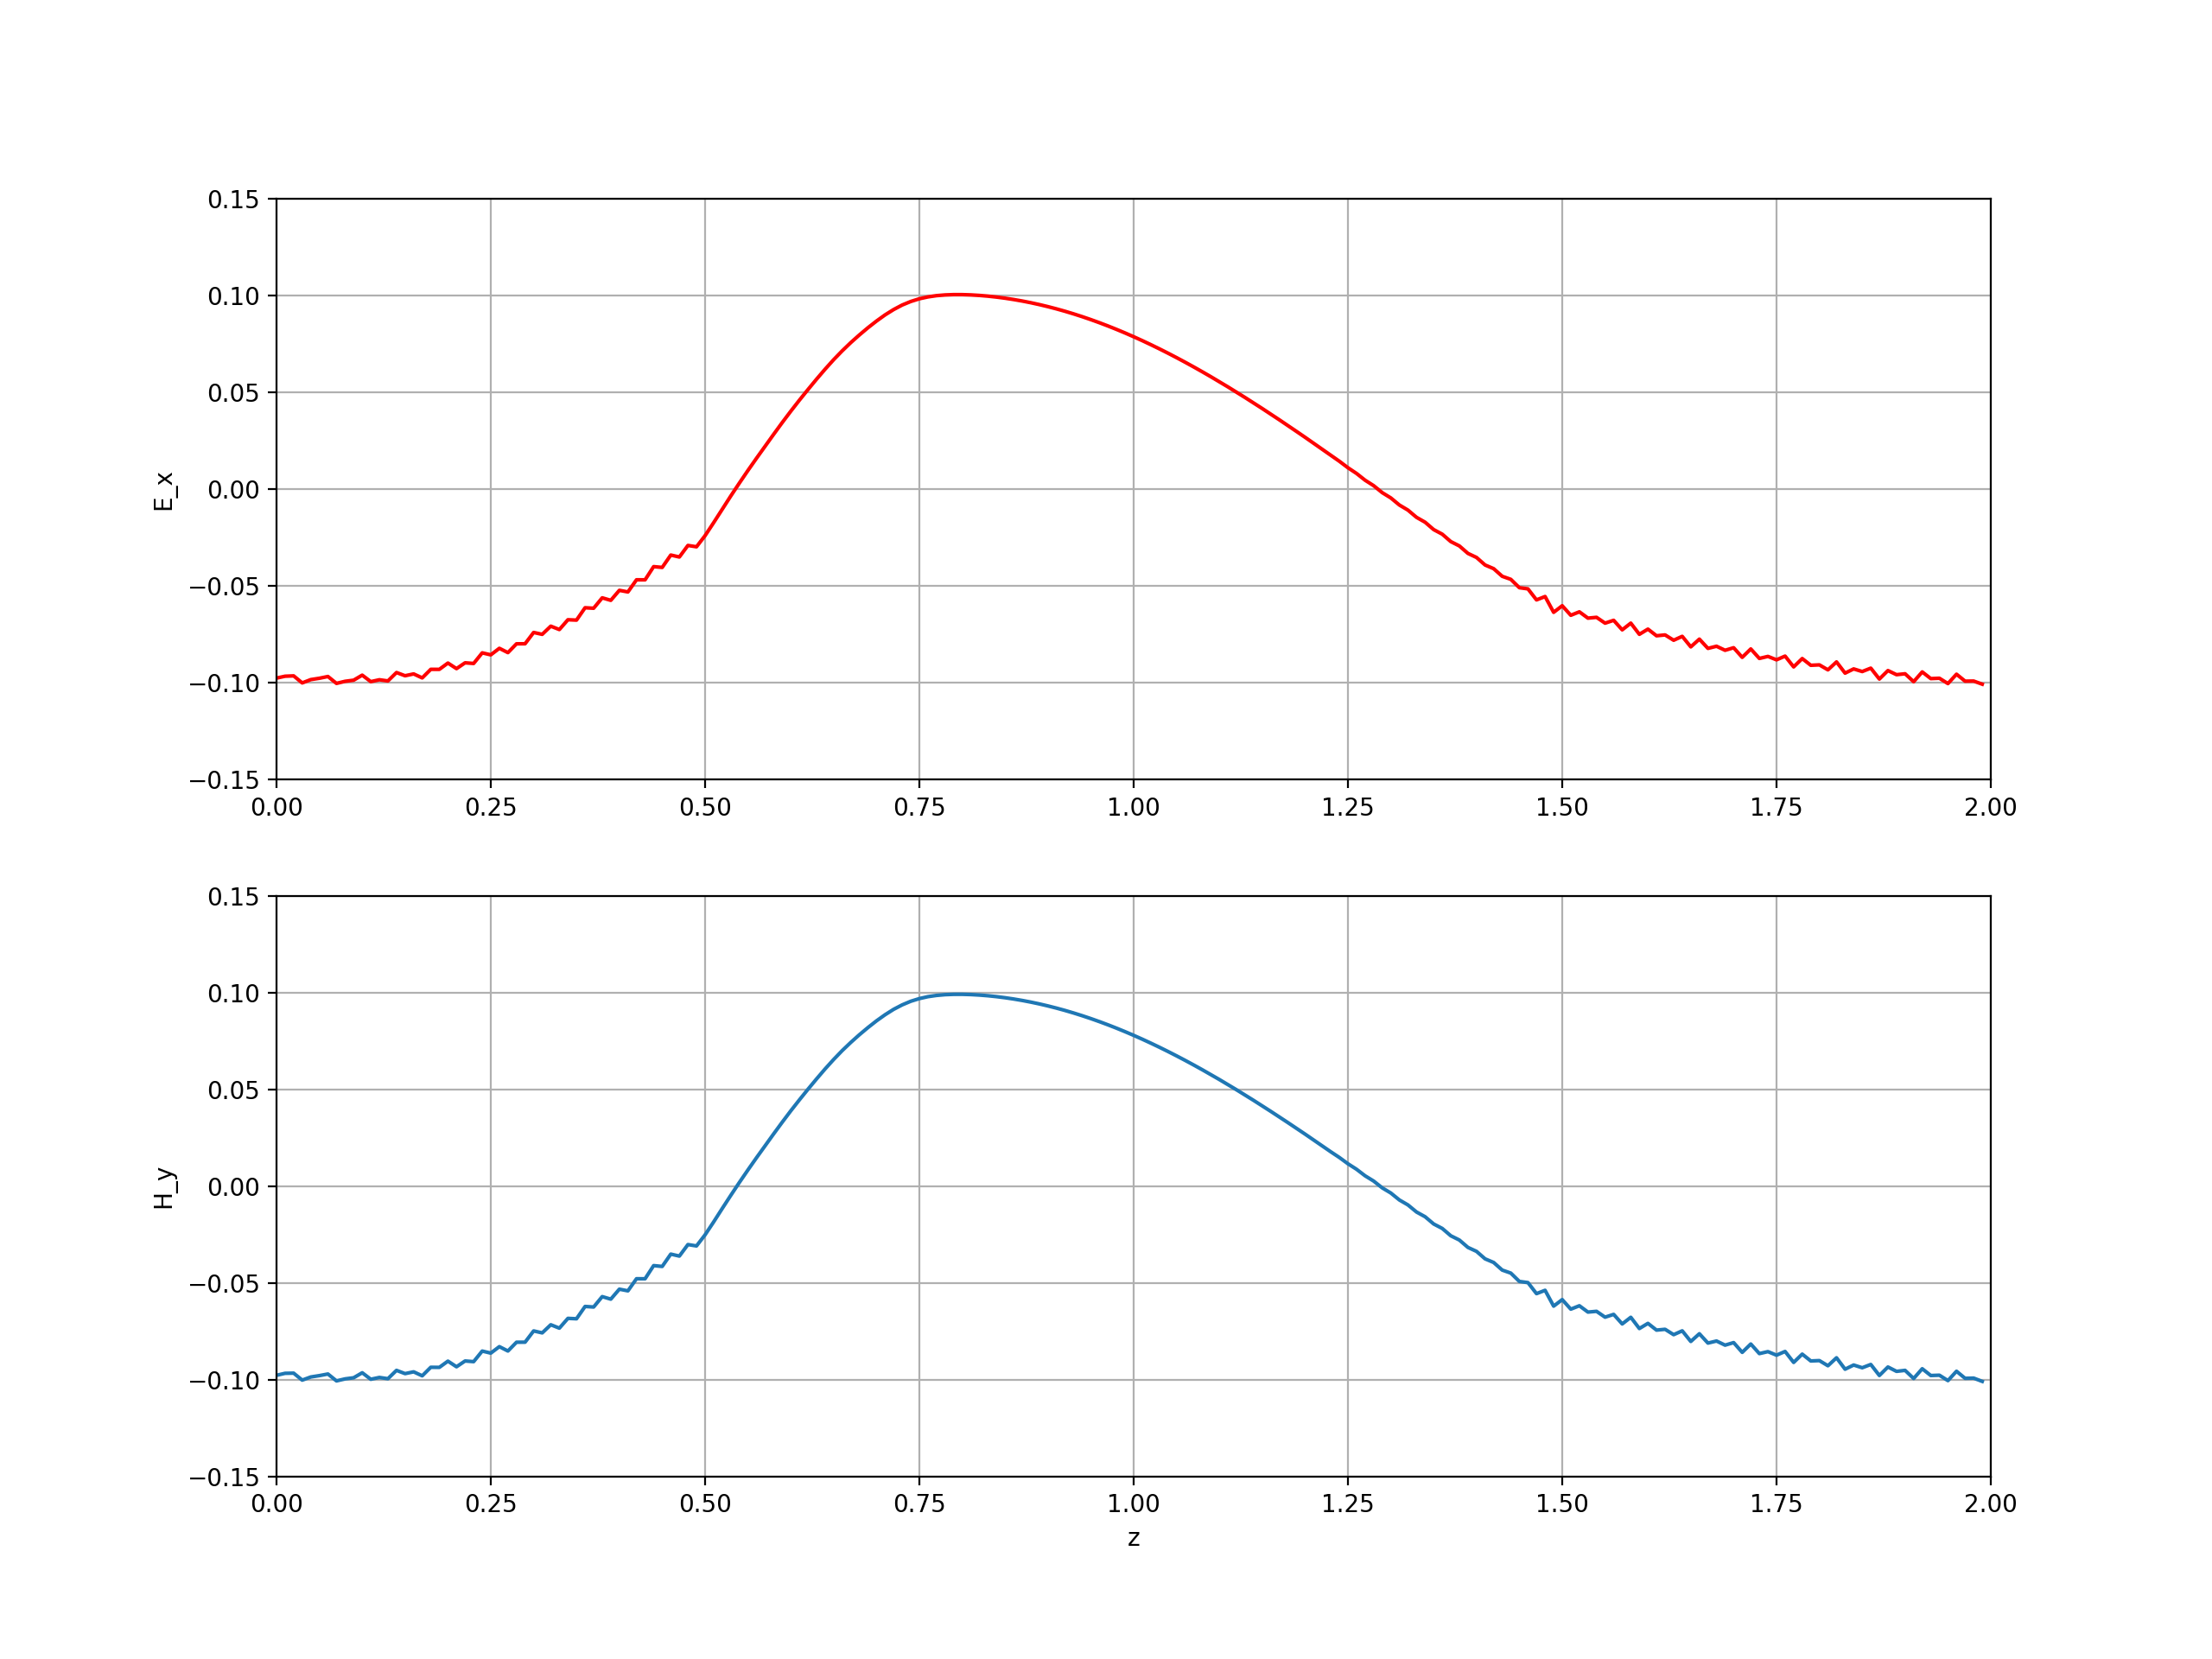

In [31]:
""" From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python eTextBook  
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# FDTD.py  FDTD solution of Maxwell's equations in 1-D

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

zmax = 2.0
dz = 0.01
zs = np.arange(0., zmax, dz)
zsh = np.arange(0., zmax, dz) + dz/2

print(zs, zsh)

ts = 2                          # time buffer switch
c = 0.4
dt = 0.001
#beta = c * dt / dz
beta = np.zeros(len(zs))
beta[:] = c * dt / dz
beta[int(len(zs)/4):int(3*len(zs)/4)] *= 0.5
print('beta =', beta)

Ex = np.zeros((len(zs),ts))      # init E 
Hy = np.zeros((len(zs),ts))      # init H 

fig = plt.figure()
ax1 = fig.add_subplot(211, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax2 = fig.add_subplot(212, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax1.grid(); ax2.grid()
ax2.set_xlabel('z')
ax1.set_ylabel('E_x'); ax2.set_ylabel('H_y')

ex_curve, = ax1.plot(zs, Ex[:,0], '-r')
hy_curve, = ax2.plot(zs, Hy[:,0], '-')

def init():
    Ex[:,0] = 0.1*np.sin(2*np.pi*zs/zmax)
    Hy[:,0] = 0.1*np.sin(2*np.pi*zsh/zmax)
    ex_curve.set_ydata(Ex[:,0])
    hy_curve.set_ydata(Hy[:,0])
    return ex_curve, hy_curve

def animate(i):
    Ex[1:-1,1] = Ex[1:-1,0] + beta[1:-1]*(Hy[0:-2,0]-Hy[2:,0])
    Hy[1:-1,1] = Hy[1:-1,0] + beta[1:-1]*(Ex[0:-2,0]-Ex[2:,0])

    Ex[0,1]    = Ex[0,0]    + beta[0]*(Hy[-2,0]  -Hy[1,0]) # BC
    Ex[-1,1]   = Ex[-1,0]   + beta[-1]*(Hy[-2,0]  -Hy[1,0])  
    Hy[0,1]    = Hy[0,0]    + beta[0]*(Ex[-2,0]  -Ex[1,0]) # BC
    Hy[-1,1]   = Hy[-1,0]   + beta[-1]*(Ex[-2,0] - Ex[1,0]) 
    
    Ex[:,0] = Ex[:,1]                            # New->old
    Hy[:,0] = Hy[:,1]                                  
    
    ex_curve.set_ydata(Ex[:,0])
    hy_curve.set_ydata(Hy[:,0])
    return ex_curve, hy_curve

ani = animation.FuncAnimation(fig, animate, np.arange(1, 10000),
                              interval=1, blit=True, init_func=init)

The changes in $\beta$ seem to be particularly good at inducing instabilities.
Are there any tricks you can play to stave off the instabilities?

You may have noticed that we are updating $E_x$ and $H_y$ at the same time intervals, when they should really be staggered.

In the following implementation, we update $E_x$ on the even time interval, and we update $H_y$ on the odd time interval.

Questions: 
* Should we use $2\Delta t$ here in the difference equations instead of $\Delta t$?  
* Does it matter?  Why or why not?

<IPython.core.display.Javascript object>


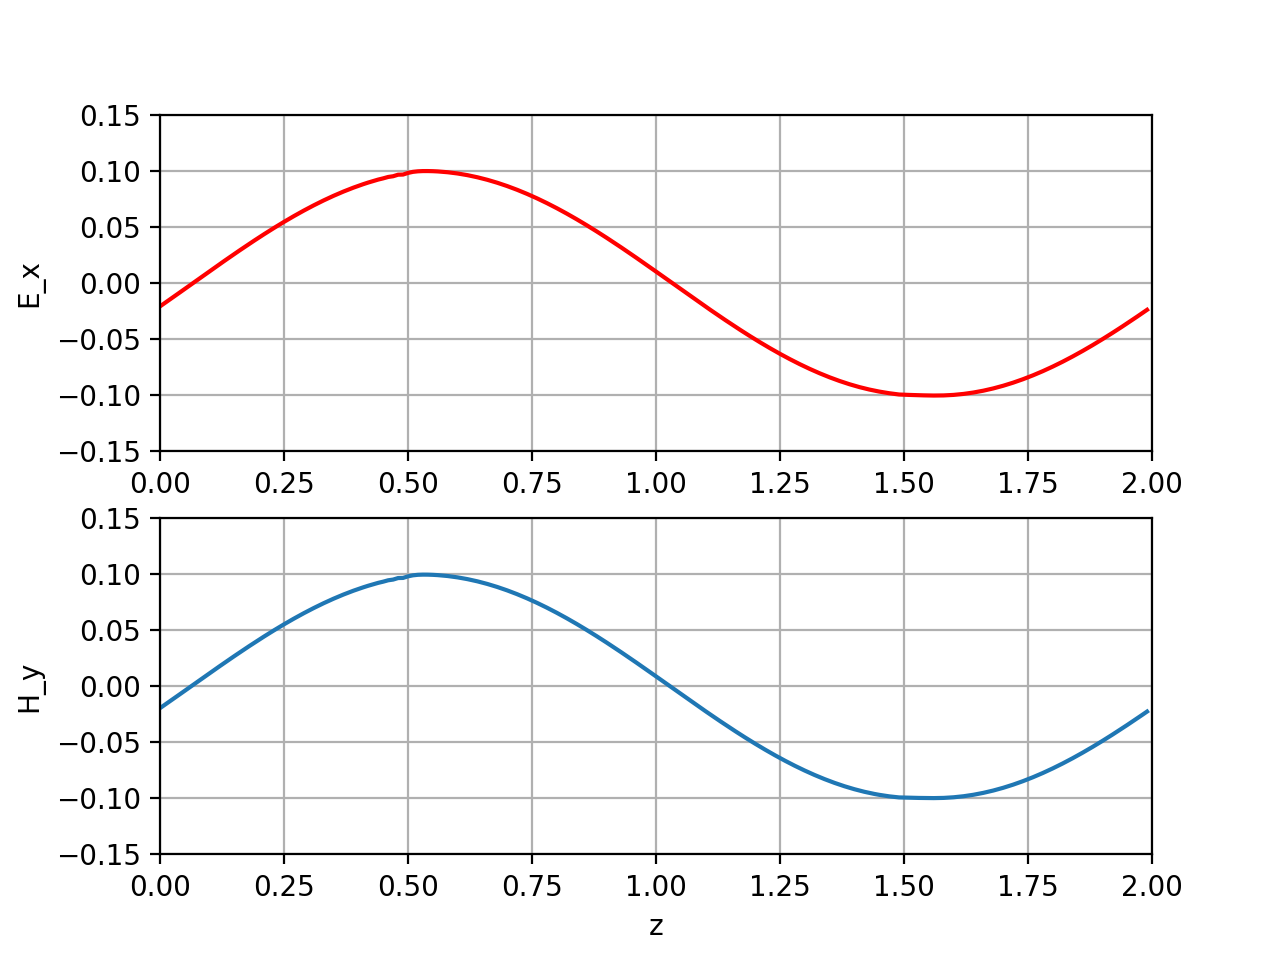

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(211, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax2 = fig.add_subplot(212, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax1.grid(); ax2.grid()
ax2.set_xlabel('z')
ax1.set_ylabel('E_x')
ax2.set_ylabel('H_y')

ex_curve, = ax1.plot(zs, Ex[:,0], '-r')
hy_curve, = ax2.plot(zs, Hy[:,0], '-')

def animate_staggered(i):
    if (i%2 == 0) :
        Ex[1:-1,1] = Ex[1:-1,0] + beta[1:-1]*(Hy[0:-2,0]-Hy[2:,0])
        Ex[0,1]    = Ex[0,0]    + beta[0]*(Hy[-1,0]  -Hy[1,0]) # BC
        Ex[-1,1]   = Ex[-1,0]   + beta[-1]*(Hy[-2,0]  -Hy[0,0])  
        Ex[:,0] = Ex[:,1]                            # New->old
    else:
        Hy[1:-1,1] = Hy[1:-1,0] + beta[1:-1]*(Ex[0:-2,0]-Ex[2:,0])
        Hy[0,1]    = Hy[0,0]    + beta[0]*(Ex[-1,0]  -Ex[1,0]) # BC
        Hy[-1,1]   = Hy[-1,0]   + beta[-1]*(Ex[-2,0] - Ex[0,0]) 
        Hy[:,0] = Hy[:,1]                                  
    
    ex_curve.set_ydata(Ex[:,0])
    hy_curve.set_ydata(Hy[:,0])
    return ex_curve, hy_curve

ani = animation.FuncAnimation(fig, animate_staggered, np.arange(1, 10000),
                              interval=1, blit=True, init_func=init)

We see that there are some instabilities, but they do not grow as fast as in the previous implementation, and they seem to be self-stabilizing after a while.

Now let's go back to the original setup and use the fully-staggered evaluations in time and space, without any discontinuous $\beta$ values..

beta = 0.1


<IPython.core.display.Javascript object>


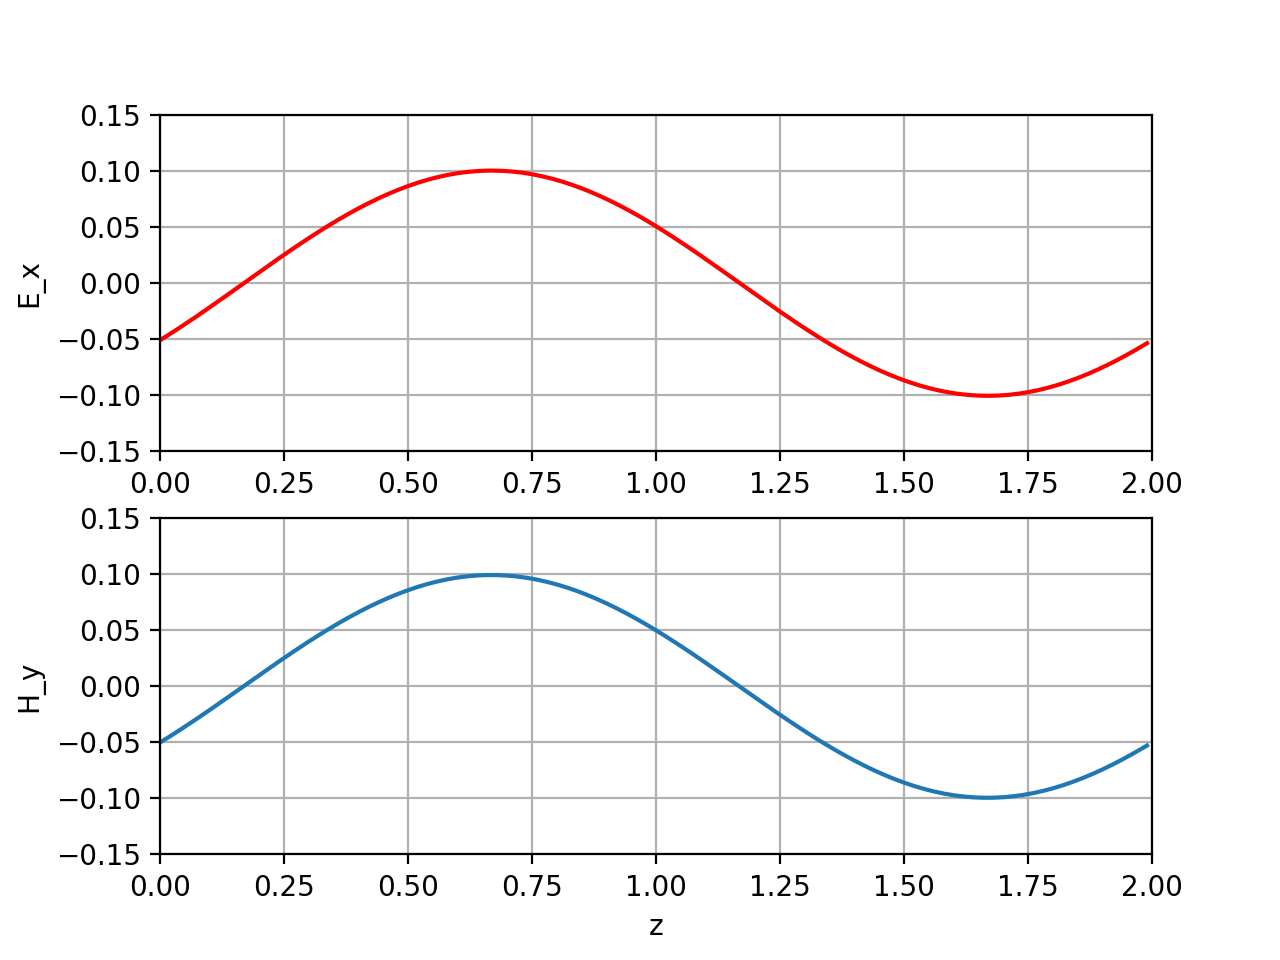

In [33]:
%matplotlib notebook
from pylab import *

import matplotlib.animation as animation

zmax = 2.0
dz = 0.01
zs = arange(0., zmax, dz)
zsh = np.arange(0., zmax, dz) + dz/2

ts = 2                          # time buffer switch
c = 1.0
dt = 0.001
beta = c * dt / dz
print('beta =', beta)
Ex = zeros((len(zs),ts),float)      # init E 
Hy = zeros((len(zs),ts),float)      # init H 

fig = plt.figure()
ax1 = fig.add_subplot(211, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax2 = fig.add_subplot(212, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax1.grid(); ax2.grid()
ax2.set_xlabel('z')
ax1.set_ylabel('E_x'); ax2.set_ylabel('H_y')

ex_curve, = ax1.plot(zs, Ex[:,0], '-r')
hy_curve, = ax2.plot(zs, Hy[:,0], '-')

def init():
    Ex[:,0] = 0.1*sin(2*pi*zs/zmax)
    Hy[:,0] = 0.1*sin(2*pi*zsh/zmax)
    ex_curve.set_ydata(Ex[:,0])
    hy_curve.set_ydata(Hy[:,0])
    return ex_curve, hy_curve

def animate_staggered(i):
    if (i%2 == 0) :
        Ex[1:-1,1] = Ex[1:-1,0] + beta*(Hy[0:-2,0]-Hy[2:,0])
        Ex[0,1]    = Ex[0,0]    + beta*(Hy[-1,0]  -Hy[1,0]) # BC
        Ex[-1,1]   = Ex[-1,0]   + beta*(Hy[-2,0]  -Hy[0,0])  
        Ex[:,0] = Ex[:,1]                            # New->old
    else:
        Hy[1:-1,1] = Hy[1:-1,0] + beta*(Ex[0:-2,0]-Ex[2:,0])
        Hy[0,1]    = Hy[0,0]    + beta*(Ex[-1,0]  -Ex[1,0]) # BC
        Hy[-1,1]   = Hy[-1,0]   + beta*(Ex[-2,0] - Ex[0,0]) 
        Hy[:,0] = Hy[:,1]                                  
    
    ex_curve.set_ydata(Ex[:,0])
    hy_curve.set_ydata(Hy[:,0])
    return ex_curve, hy_curve

ani = matplotlib.animation.FuncAnimation(fig, animate_staggered, np.arange(1, 10000),
                                         interval=1, blit=True, init_func=init)



## Circular Polarization

In the previous examples, we have assumed a linear polarization perfectly aligned along $x$ for $E$ and along $y$ for $H$.

Now we would like to allow the fields to be polarized in any plane transverse to the $z$ axis.
We need to add the missing $x$ and $y$ components for Maxwell's equations:

$$\begin{align}
  \frac{\partial H_x}{\partial t} & =   \frac{1}{\mu_0} \frac{\partial E_y} {\partial z}  \\
  \frac{\partial E_y}{\partial t} & =  \frac{1}{\epsilon_0} \frac{\partial H_x}{\partial z}
 \end{align}$$

When discretized in the same way as for $E_x$ and $H_y$, we obtain

$$\begin{align}
H_x^{k+1/2,n+1} & = H_x^{k+1/2,n}+\frac{\Delta t}{\mu_0 \Delta z} \left(E_y^{k+1,n+1/2}-E_y^{k,n+1/2}\right),\\
 E_y^{k,n+1/2} & =  E_y^{k,n-1/2}+\frac{\Delta
t}{\epsilon_0 \Delta z} \left(H_x^{k+1/2,n}-H_x^{k-1/2,n}\right)
\end{align}$$

These equations only allow us to solve for the time-stepping of components in $x$ and $y$.  They do *not* guarantee circular polarization.

To produce a circularly polarized traveling wave, we need to set the initial conditions appropriately:

$$\begin{align}
E_x &=   \cos\left(t-\frac{z}{c}   +\phi_x\right), \quad\quad 
H_x  = \sqrt{\frac{\epsilon_0}{\mu_0}}\cos\left(t-\frac{z}{c} +\phi_y\right),\\
E_y &= \cos\left(t-\frac{z}{c} +\phi_y\right), \quad\quad 
H_y =\sqrt{\frac{\epsilon_0}{\mu_0}}\cos\left(t-\frac{z}{c} -\phi_x \right)
\end{align}$$

with constant phases $\phi_x=\pi/2$ and $\phi_y=0$.

beta = 0.1


<IPython.core.display.Javascript object>


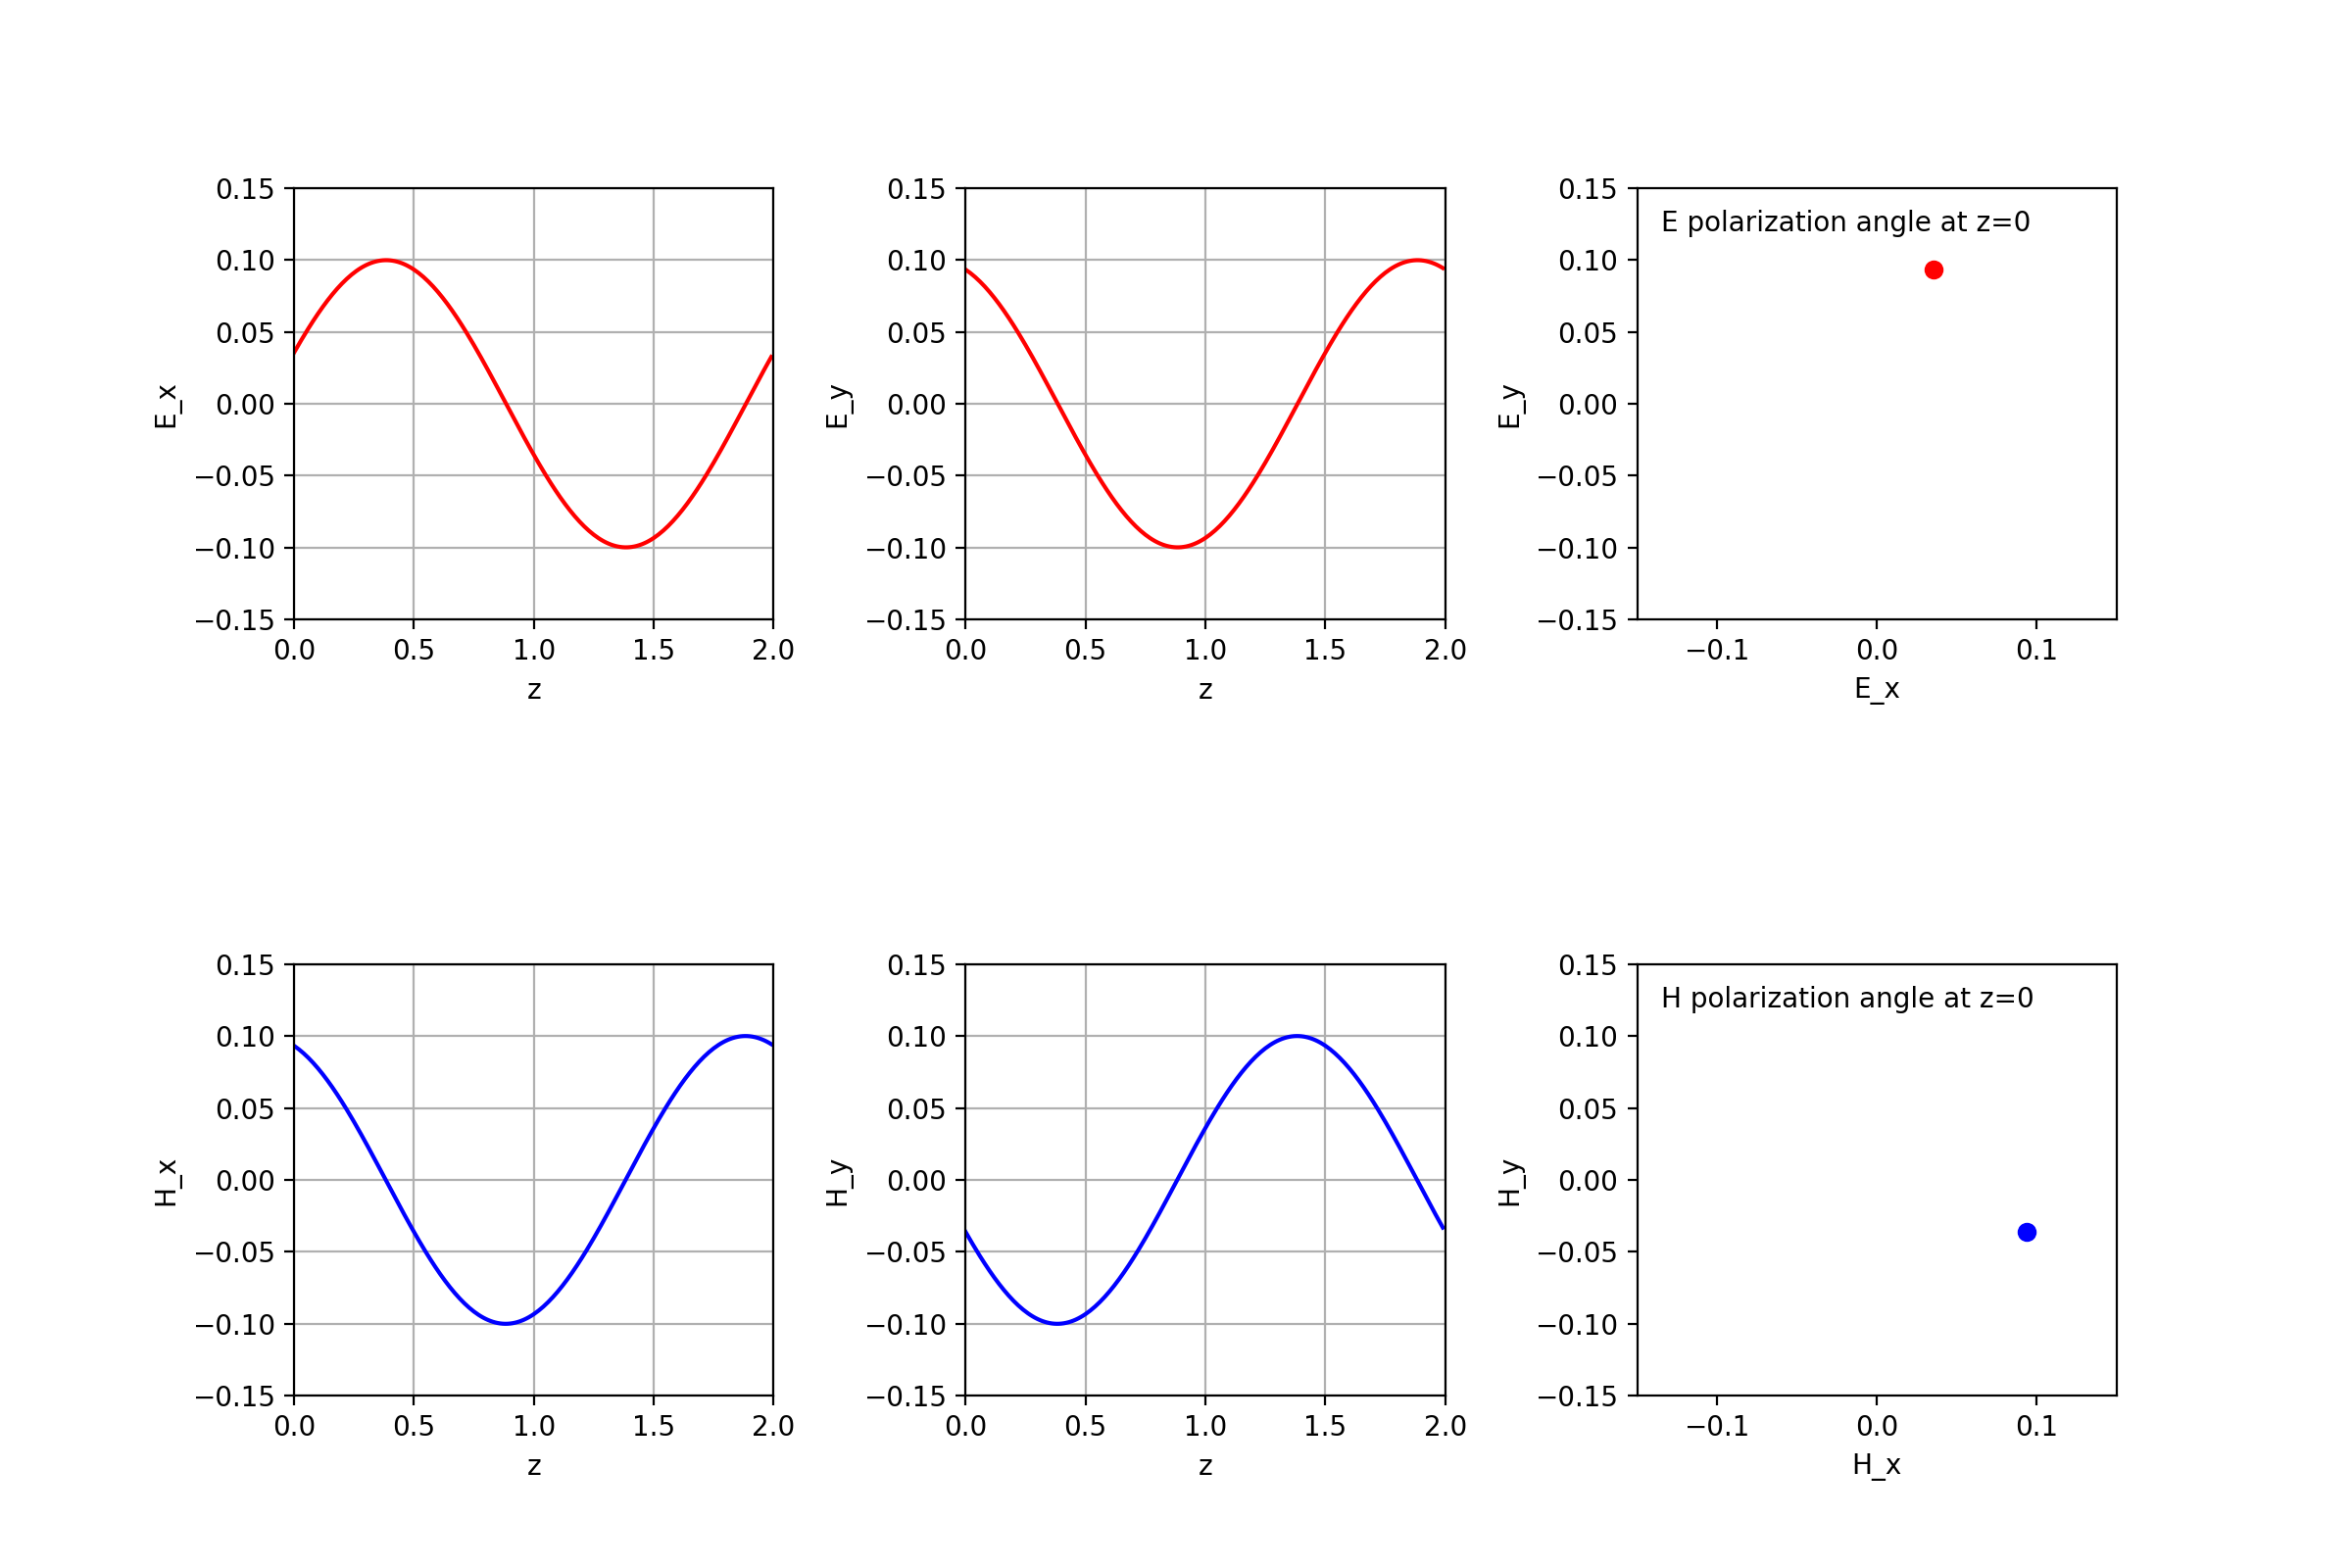

In [2]:
%matplotlib notebook
from pylab import *

import matplotlib.animation as animation

zmax = 2.0
dz = 0.01
zs = arange(0., zmax, dz)

ts = 2                          # time buffer switch (new=1, old=0)
c = 1.0
dt = 0.001
beta = c * dt / dz
print('beta =', beta)
Ex = zeros((len(zs),ts),float)      # init E 
Ey = zeros((len(zs),ts),float)
Hy = zeros((len(zs),ts),float)      # init H 
Hx = zeros((len(zs),ts),float)

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=0.4, hspace=0.8)
ax1 = fig.add_subplot(231, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax2 = fig.add_subplot(232, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax3 = fig.add_subplot(233, autoscale_on=False, xlim=(-0.15, 0.15), ylim=(-0.15, 0.15))
ax4 = fig.add_subplot(234, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax5 = fig.add_subplot(235, autoscale_on=False, xlim=(0, zmax), ylim=(-0.15, 0.15))
ax6 = fig.add_subplot(236, autoscale_on=False, xlim=(-0.15, 0.15), ylim=(-0.15, 0.15))

for ax in (ax1, ax2, ax4, ax5):
    ax.set_xlabel('z')
    ax.grid()
ax1.set_ylabel('E_x')
ax2.set_ylabel('E_y')
ax3.set_xlabel('E_x'); ax3.set_ylabel('E_y')
ax4.set_ylabel('H_x')
ax5.set_ylabel('H_y')
ax6.set_xlabel('H_x'); ax6.set_ylabel('H_y')

ex_curve,   = ax1.plot(zs, Ex[:,0], '-r')
ey_curve,   = ax2.plot(zs, Ey[:,0], '-r')
ex_ey_plot, = ax3.plot(Ex[0,0], Ey[0,0], 'or')
hx_curve,   = ax4.plot(zs, Hx[:,0], '-b')
hy_curve,   = ax5.plot(zs, Hy[:,0], '-b')
hx_hy_plot, = ax6.plot(Hx[0,0], Hy[0,0], 'ob')

ax3.text(0.05, 0.9, 'E polarization angle at z=0', transform=ax3.transAxes)
ax6.text(0.05, 0.9, 'H polarization angle at z=0', transform=ax6.transAxes)

def init():
    phx = 0.5*pi
    phy = 0.0
    Ex[:,0] = 0.1*cos(-2*pi*zs/zmax + phx)
    Ey[:,0] = 0.1*cos(-2*pi*zs/zmax + phy)
    Hx[:,0] = 0.1*cos(-2*pi*zs/zmax + phy)
    Hy[:,0] = 0.1*cos(-2*pi*zs/zmax - phx)

    ex_curve.set_ydata(Ex[:,0])
    ey_curve.set_ydata(Ey[:,0])
    ex_ey_plot.set_xdata(Ex[0,0])
    ex_ey_plot.set_ydata(Ey[0,0])
    
    hx_curve.set_ydata(Hx[:,0])
    hy_curve.set_ydata(Hy[:,0])
    hx_hy_plot.set_xdata(Hx[0,0])
    hx_hy_plot.set_ydata(Hy[0,0])
    
    return ex_curve, ey_curve, ex_ey_plot, hx_curve, hy_curve, hx_hy_plot

def animate(i):
    if (i%2 == 0):
        Ex[1:-1,1] = Ex[1:-1,0] + beta*(Hy[0:-2,0]-Hy[2:,0])
        Ey[1:-1,1] = Ey[1:-1,0] - beta*(Hx[0:-2,0]-Hx[2:,0])

        Ex[0,1]    = Ex[0,0]    + beta*(Hy[-1,0]  -Hy[1,0]) # BC
        Ex[-1,1]   = Ex[-1,0]   + beta*(Hy[-2,0]  -Hy[0,0])
        Ey[0,1]    = Ey[0,0]    - beta*(Hx[-1,0]  -Hx[1,0]) # BC
        Ey[-1,1]   = Ey[-1,0]   - beta*(Hx[-2,0]  -Hx[0,0])
        
        Ex[:,0] = Ex[:,1]                            # New->old
        Ey[:,0] = Ey[:,1]
    else:
        Hx[1:-1,1] = Hx[1:-1,0] - beta*(Ey[0:-2,0]-Ey[2:,0])
        Hy[1:-1,1] = Hy[1:-1,0] + beta*(Ex[0:-2,0]-Ex[2:,0])

        Hx[0,1]    = Hx[0,0]    - beta*(Ey[-1,0]  -Ey[1,0]) # BC
        Hx[-1,1]   = Hx[-1,0]   - beta*(Ey[-2,0] - Ey[0,0])         
        Hy[0,1]    = Hy[0,0]    + beta*(Ex[-1,0]  -Ex[1,0]) # BC
        Hy[-1,1]   = Hy[-1,0]   + beta*(Ex[-2,0] - Ex[0,0]) 
        
        Hx[:,0] = Hx[:,1]
        Hy[:,0] = Hy[:,1]                                  
    
    ex_curve.set_ydata(Ex[:,0])
    ey_curve.set_ydata(Ey[:,0])
    ex_ey_plot.set_xdata(Ex[0,0])
    ex_ey_plot.set_ydata(Ey[0,0])

    hx_curve.set_ydata(Hx[:,0])
    hy_curve.set_ydata(Hy[:,0])
    hx_hy_plot.set_xdata(Hx[0,0])
    hx_hy_plot.set_ydata(Hy[0,0])
    

    return ex_curve, ey_curve, ex_ey_plot, hx_curve, hy_curve, hx_hy_plot

ani = matplotlib.animation.FuncAnimation(fig, animate, np.arange(1, 10000),
                                         interval=1, blit=True, init_func=init)



You can see from the polarization angle plots why it is called "circular polarization."